<a href="https://colab.research.google.com/github/lilanpei/NMT/blob/master/NMT_Microblog_ZH_to_EN_Bi_GRU_%2B_Attention_%2B_Fasttext_word_embedding_%2B_k_Beam_search_%2B_BLEU_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth corpus (Tico-19)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


In [ ]:
!nvidia-smi

Wed Jul 28 12:15:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install setGPU
import setGPU

setGPU: Setting GPU to: 0


In [ ]:
path_ku = '/content/kurdishall.txt'
path_en = '/content/englishall.txt'

## Preprocessing data:


In [ ]:
import re

import io
import unicodedata
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S


# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def fa_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = re.sub(r"[\u200c\u4e00-\u9fa5]+", r" ", s)
    s = s.strip()


    return s

# Create input/target dataset
def create_dataset(path_ku, path_en, num_examples=None):
    kurdish_sentences = io.open(path_ku, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    kurdish_sentences = [ku_normalizeString(s) for s in kurdish_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return kurdish_sentences, english_sentences

# Tokenize
def tokenize(lang, num_words):
    lang_tokenizer = T.Tokenizer(num_words=num_words,filters='', oov_token='<UNK>')
    lang_tokenizer.fit_on_texts(lang)
    lang_tokenizer.word_index = {e:i for e,i in lang_tokenizer.word_index.items() if i <= lang_tokenizer.num_words}
    lang_tokenizer.index_word = dict(map(reversed, lang_tokenizer.word_index.items()))
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

# Transform word to index
def load_dataset(path_to_file_ku, path_to_file_en, num_examples=None, num_words=80000000):#we put num_word like this in order to get the whole corpus but we can make it small if we get memory error
    inp_lang, targ_lang  = create_dataset(path_to_file_ku, path_to_file_en, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang, num_words*2 if num_words else None)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang, num_words)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
create_dataset(path_fa, path_en, num_examples=10)

(['بە ناوی خوای بەخشندەی میهرەبان .',
  'سوپاس و ستایش هەر شایستەی خوایە و بۆ خوایە، کە خاوەن و پەروەردگاری هەموو جیهانیان و هەموو بوونەوەره.',
  'بەخشندەی میهرەبان ، کانگای ڕەحمەت و میهرەبانیە .',
  'خاوەن و سەرداری ڕۆژی پاداشت و سزایە .',
  'خوایە، تەنها هەر تۆ دەپەرستین و هەر لەتۆش داوای یارمەتی و پشتیوانی دەکەین .',
  'خوایە بەردەوام ڕێنمووییمان بفەرموو بۆ ئەم ڕێبازی ڕاست و دروستی ئیسلامە.',
  'کە بەرنامە و ڕێبازی ئەوانەیە لە نازو نیعمەتی خۆت بەهرەوەرت کردوون، نەمانخەیتە سەر ڕێبازی ئەوانەی خەشم و قینیان لێگیراوە ، هەروەها نەمانخاتە سەر ڕێبازی ئەوانەش، کە سەرگەردان و گومڕان',
  'ئەو قورئانە کتێبێکە هیچ گومانێکی تێدا نیە، .',
  'ئەوانەی باوەڕ بە نەبینراوەکان دەهێنن ، هەروەها نوێژەکانیان بەچاکی ئەنجام دەدەن و لەو ڕزق و ڕۆزییهپێمان بەخشیوون، دەبەخشن.',
  'ئەوانە باوەڕ دەهێنن بەوکە بۆ تۆدابەزێنراوە و بەو پەیامانەش کە بۆپێش تۆ دابەزێنراوە، دڵنیاش دەبن کە ڕۆژی دوایی پێش دێت و قیامەت هەر بەرپا دەبێت.'],
 ['<start> in the name of allah , most benevolent , ever merciful . <end>',
  '<start> 

## Shuffle the data, define the batch generator

In [ ]:
import random
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
def prepare_training_data(input_file_path):
    # Try experimenting with the size of that dataset by setting num_examples
    input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_file_path[0], input_file_path[1])
    input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
    # Creating training and validation sets using an 80-20 split
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

    # Input tokens for encoder/decoder zero padded
    num_encoder_tokens, num_decoder_tokens = len(inp_lang.index_word) - 1, len(targ_lang.index_word) + 1
    print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

    # Number of Training/validation samples
    N_train_samples = 4000
    N_val_samples = 1000
    print('Number of samples for Training/Test: {}, {}'.format(N_train_samples, N_val_samples))
    
    # Max length of input/target sentences
    max_length_inp = max([len(sent) for sent in input_tensor])
    max_length_targ = max([len(sent[:-1]) for sent in target_tensor])

    print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

    return input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, \
            inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens, \
            N_train_samples, N_val_samples, \
            max_length_inp, max_length_targ

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size):
    while True:
        for i in range(0, min(len(input_tensor),(len(input_tensor)//batch_size)*batch_size), batch_size):
            encoder_input_batch = input_tensor[i:i + batch_size]
            encoder_input_batch = S.pad_sequences(encoder_input_batch,padding='post', maxlen = max_length_inp, truncating='post')
            decoder_input_batch = target_tensor[i:i + batch_size]
            decoder_input_batch = S.pad_sequences([s[:-1] for s in decoder_input_batch],\
                                                  padding='post', maxlen = max_length_targ, truncating='post')
            decoder_target_batch = target_tensor[i:i + batch_size]
            decoder_target_batch = np.array([to_categorical(t,len(targ_lang.word_index) + 1) \
                                             for t in S.pad_sequences([s[1:] \
                                             for s in decoder_target_batch],padding='post', maxlen = max_length_targ, truncating='post')])
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

## Load the prepared data

In [ ]:
#__main()__
input_file_path = ['/content/kurdishall.txt',\
                   '/content/englishall.txt']

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, inp_lang, targ_lang, \
num_encoder_tokens, num_decoder_tokens, \
N_train_samples, N_val_samples, \
max_length_inp, max_length_targ = prepare_training_data(input_file_path) 

Number of input tokens for encoder/decoder with zero padding: 133720, 53950
Number of samples for Training/Test: 4000, 1000
Max length of input/target sentences: 270, 348


## Get embedding matrix

In [ ]:
# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
!pip3 install wget
import gzip
import os
import tarfile
import wget
import os.path
from os import path
import numpy as np

# Download pre-trained Fasttext word embedding
def download_fasttext_word_embedding(pre_trained_vector_paths):
  if not path.exists(pre_trained_vector_paths[0]):
    print('Downloading cc.ckb.300.vec.gz ......')
    wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ckb.300.vec.gz",\
                out = pre_trained_vector_paths[0][:-13] + "cc.ckb.300.vec.gz")
    with gzip.open(pre_trained_vector_paths[0][:-13] + "cc.ckb.300.vec.gz", 'rb') as f,\
           open(pre_trained_vector_paths[0], 'wb') as f_out:
      f_out.write(f.read())
    # delete cc.fa.300.vec.gz after unzip cause it is too large
    os.remove(pre_trained_vector_paths[0][:-13] + "cc.ckb.300.vec.gz")
  else :
    print('File  already exists : {}'.format(pre_trained_vector_paths[0]))

  if not path.exists(pre_trained_vector_paths[1]):
    print('Downloading cc.en.300.vec.gz ......')
    wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz",\
                out = pre_trained_vector_paths[0][:-13] + "cc.en.300.vec.gz")
    with gzip.open(pre_trained_vector_paths[1][:-13] + "cc.en.300.vec.gz", 'rb') as f,\
           open(pre_trained_vector_paths[1], 'wb') as f_out:
      f_out.write(f.read())
    # delete cc.en.300.vec.gz after unzip cause it is too large
    os.remove(pre_trained_vector_paths[1][:-13] + "cc.en.300.vec.gz")
  else :
    print('File  already exists : {}'.format(pre_trained_vector_paths[1]))

def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(pre_trained_vector_paths, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(pre_trained_vector_paths)
    print('number of trained word vector: {}:{}'.format(pre_trained_vector_paths, len(trained_word_vec)))

    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def map_word_with_pretrained_word_embedding(pre_trained_vector_paths, word2index_inp, word2index_targ,\
                                            num_encoder_tokens, num_decoder_tokens, vector_size = 300):
    # Creating input embedding vectors
    input_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[0], word2index_inp, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[1], word2index_targ, vector_size, num_decoder_tokens)
    # Save output embedding vectors
    np.save(output_file_path[0], input_emb_matrix)
    np.save(output_file_path[1], output_emb_matrix)

In [ ]:
# Train a FastText model for word-embedding
from gensim.models import FastText
import numpy as np

def get_embedding_matrix_from_fast_model(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))
    
    for word, idx in word2index.items():
        try:
            word_vec = fast_model.wv.word_vec(word)
        except KeyError:
              print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def train_fasttext_model(input_file_path, output_file_path, vector_size = 100):
    inps, targs  = create_dataset(input_file_path[0], input_file_path[1])
    tokens_zh = [[token for token in sents.split()] for sents in inps]
    tokens_en = [[token for token in sents.split()] for sents in targs]
    fast_model_zh = FastText(tokens_zh, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)
    fast_model_en = FastText(tokens_en, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)
    input_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)

    # Save output embedding vectors
    np.save(output_file_path[0] + "_trained", input_emb_matrix)
    np.save(output_file_path[1] + "_trained", output_emb_matrix)

In [ ]:
import os.path
from os import path
import numpy as np

def load_word_embedding(pre_trained_vector_paths, output_file_path, inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens):
    if not flag: 
        print("Using pre_trained FastText word_embedding :")
        download_fasttext_word_embedding(pre_trained_vector_paths)
        if not path.exists(output_file_path[0] + ".npy") or not path.exists(output_file_path[1] + ".npy"):
            map_word_with_pretrained_word_embedding(pre_trained_vector_paths, inp_lang.word_index, targ_lang.word_index, \
                                                    num_encoder_tokens, num_decoder_tokens)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + ".npy", output_file_path[1] + ".npy"))
        input_emb_matrix, output_emb_matrix = np.load(output_file_path[0] + ".npy"), np.load(output_file_path[1] + ".npy")
    else :
        print("Train a fasttext model to get word_embedding :")
        if not path.exists(output_file_path[0] + "_trained.npy") or not path.exists(output_file_path[1] + "_trained.npy"):
            train_fasttext_model(input_file_path, output_file_path)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + "_trained", output_file_path[1] + "_trained"))
        input_emb_matrix, output_emb_matrix= np.load(output_file_path[0] + "_trained.npy"), np.load(output_file_path[1] + "_trained.npy")

    print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

    return input_emb_matrix, output_emb_matrix

In [ ]:
# download the vec files (8 Gigabyte for both English and Persian) and uploaded them to coaab drive coz you might ram crush error.
pre_trained_vector_paths = ['/content/drive/MyDrive/cc.ckb.300.vec', '/content/drive/MyDrive/cc.en.300.vec']
output_file_path = ['/content/drive/MyDrive/input_emb_matrix_Microblog', '/content/drive/MyDrive/output_emb_matrix_Microblog']
flag = 0 # 0 : using pre_trained word_embedding, 1 : train a fasttext model to get word_embedding
input_emb_matrix, output_emb_matrix = load_word_embedding(pre_trained_vector_paths, output_file_path,\
                                inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens)

Using pre_trained FastText word_embedding :
File  already exists : /content/drive/MyDrive/cc.ckb.300.vec
File  already exists : /content/drive/MyDrive/cc.en.300.vec
File  already exists : /content/drive/MyDrive/input_emb_matrix_Microblog.npy, /content/drive/MyDrive/output_emb_matrix_Microblog.npy
Embedding-matrix shape: (133722, 300), (53950, 300)


## Built the Seq2seq model

In [ ]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# AttentionLayer from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


def built_model(batch_size = 10, latent_dim = 300):
    # Set up the encoder
    encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
    enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
    enc_emb = enc_emb_layer(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    print('encoder_inputs/enc_emb shape: {}, {}'.format(encoder_inputs.shape, enc_emb.shape))
    encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
    encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
    # Embedding with with pre-trained embedding word vectors
    dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
    dec_emb = dec_emb_layer(decoder_inputs)
    # We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    print('decoder_inputs/dec_emb shape: {}, {}'.format(decoder_inputs.shape, dec_emb.shape))
    decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    # Concat attention input and decoder GRU output
    print('decoder_outputs/attn_out shape: {}, {}'.format(decoder_outputs.shape, attn_out.shape))
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    # Dense layer
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
    decoder_outputs = dense_time(decoder_concat_input)

    # Define the model that takes encoder and decoder input to output decoder_outputs
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #len_decoder_inputs = len(decoder_inputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    return enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model

encoder_inputs/enc_emb shape: (10, 270), (10, 270, 300)
decoder_inputs/dec_emb shape: (10, 348), (10, 348, 300)
decoder_outputs/attn_out shape: (10, 348, 600), (10, 348, 600)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(10, 270)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (10, 270, 300)       40116000    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(10, 348)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bid

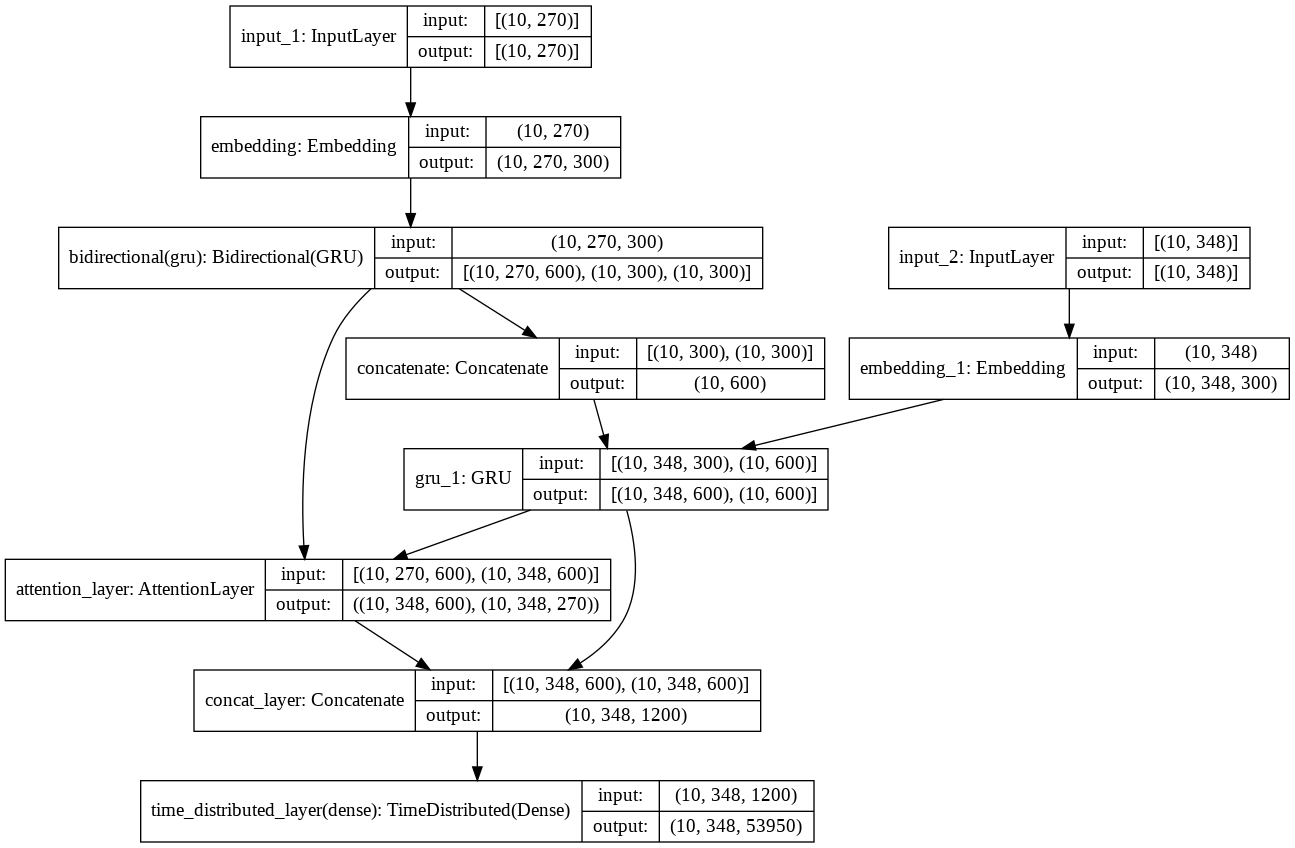

In [ ]:
#__main()__
enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model = built_model(batch_size = 10, latent_dim = 300)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Train the model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val,\
                    N_train_samples, N_val_samples, batch_size = 10, epochs = 15):
    history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = N_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = N_val_samples//batch_size)
    return history

def plot_training_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(val_loss_values) + 1)

    plt.subplot(211)
    plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Test loss')
    plt.title('Training and val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Val accuracy')
    plt.title('Training and val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
400/400 [==============================] - 1031s 3s/step - loss: 0.2491 - acc: 0.9571 - val_loss: 0.2234 - val_acc: 0.9616
Epoch 2/15
400/400 [==============================] - 1020s 3s/step - loss: 0.2352 - acc: 0.9591 - val_loss: 0.2551 - val_acc: 0.9561
Epoch 3/15
400/400 [==============================] - 1022s 3s/step - loss: 0.2407 - acc: 0.9577 - val_loss: 0.2404 - val_acc: 0.9585
Epoch 4/15
400/400 [==============================] - 1017s 3s/step - loss: 0.2390 - acc: 0.9578 - val_loss: 0.2295 - val_acc: 0.9604
Epoch 5/15
400/400 [==============================] - 1020s 3s/step - loss: 0.2231 - acc: 0.9603 - val_loss: 0.2373 - val_acc: 0.9589
Epoch 6/15
400/400 [==============================] - 1026s 3s/step - loss: 0.2214 - acc: 0.9604 - val_loss: 0.2242 - val_acc: 0.9611
Epoch 7/15
400/400 [==============================] - 1029s 3s/step - loss: 0.2196 - acc: 0.9605 - val_loss: 0.2150 - val_acc: 0.9626
Epoch 8/15
400/400 [==============================] - 1021s 3s

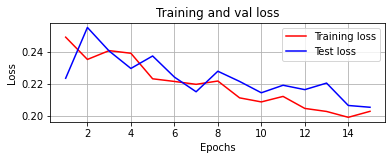

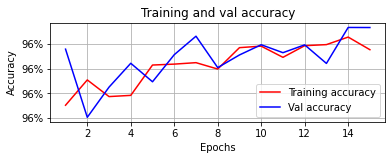

In [ ]:
#__main()__
history = train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val, N_train_samples, N_val_samples)
plot_training_history(history)

## Built the inference model

In [ ]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib.font_manager as fm

fontprop = fm.FontProperties(fname=None, size=10)
plt.rcParams['axes.unicode_minus'] = True  

# plot_attention_weights function from https://github.com/thushv89/attention_keras/blob/master/src/examples/utils/model_helper.py
def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fa_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))
        
def built_inference_model(batch_size = 1, latent_dim = 300):
    # Encoder (Inference) model
    encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
    enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
    # Encode the input sequence to get the "Context vectors"
    encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])
    encoder_model.summary()

    # Decoder (Inference) model
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
    encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
    decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
    # Get the embeddings of the decoder sequence
    dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
    # Final decoder model
    decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],\
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    decoder_model.summary()

    return encoder_model, decoder_model

# decode token with k beam search
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay [(1, 270)]                0         
_________________________________________________________________
embedding (Embedding)        multiple                  40116000  
_________________________________________________________________
bidirectional (Bidirectional multiple                  1081800   
Total params: 41,197,800
Trainable params: 1,081,800
Non-trainable params: 40,116,000
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer [(1, 1)]             0                                            
_______________________________________________________

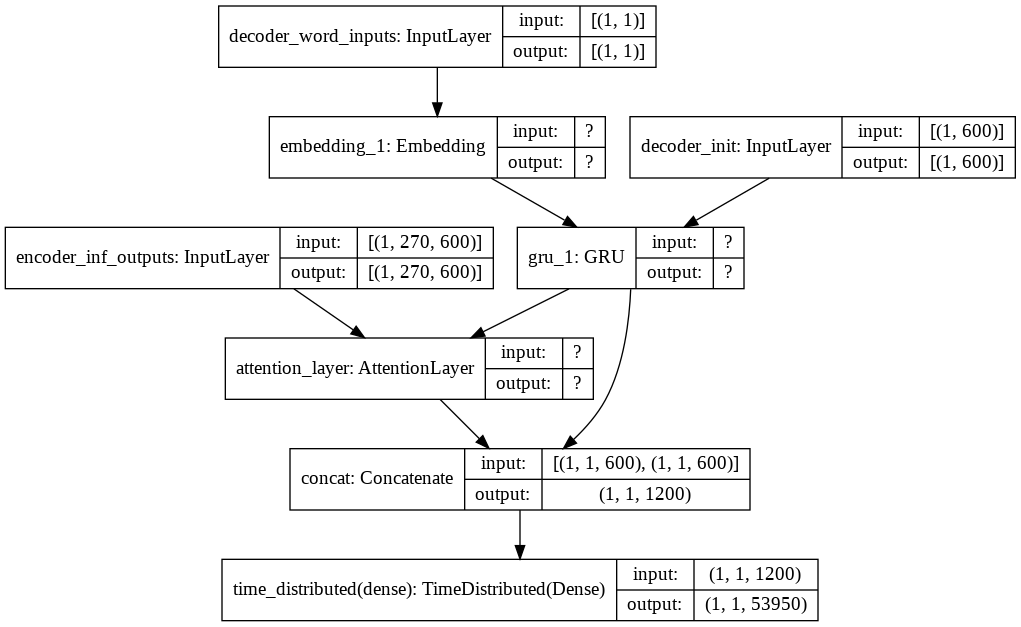

In [ ]:
#__main()__
encoder_model, decoder_model = built_inference_model(batch_size = 1, latent_dim = 300)
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

## Make predictions on the Test dataset

In [ ]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

# Attention plotting

Input Source sentence: جا ئیتر کێ لەو کەسە گومڕاترە کە دوعا و نزا و پاڕانەوە، ڕوو بەکەسێک یان شتێک دەکات، جگە لەخوا کە ئەگەر هەتا ڕۆژی قیامەتیش لێی بپاڕێتەوە بێ سوودە، نەبەهانایەوە دەچێت، نەبەپەرستنەکەش دەزانێت، لەکاتێکدا ئەوانەلەدۆعاو پارانەوەی ئەوان بێ ئاگا و غافڵن و هەستی پێ ناکەن.
Actual Target Translation: who is more wrong than him who invokes , besides god , those who will not answer him until the day of resurrection , and are heedless of their prayers ?
Predicted Target Translation: who is more unjust than he who invents a lie to allah , or is he who says , that is the day of resurrection , when it comes to him , that is the day of resurrection , when it comes to him , he says , my lord , do you not know that i do not know that they do not know .


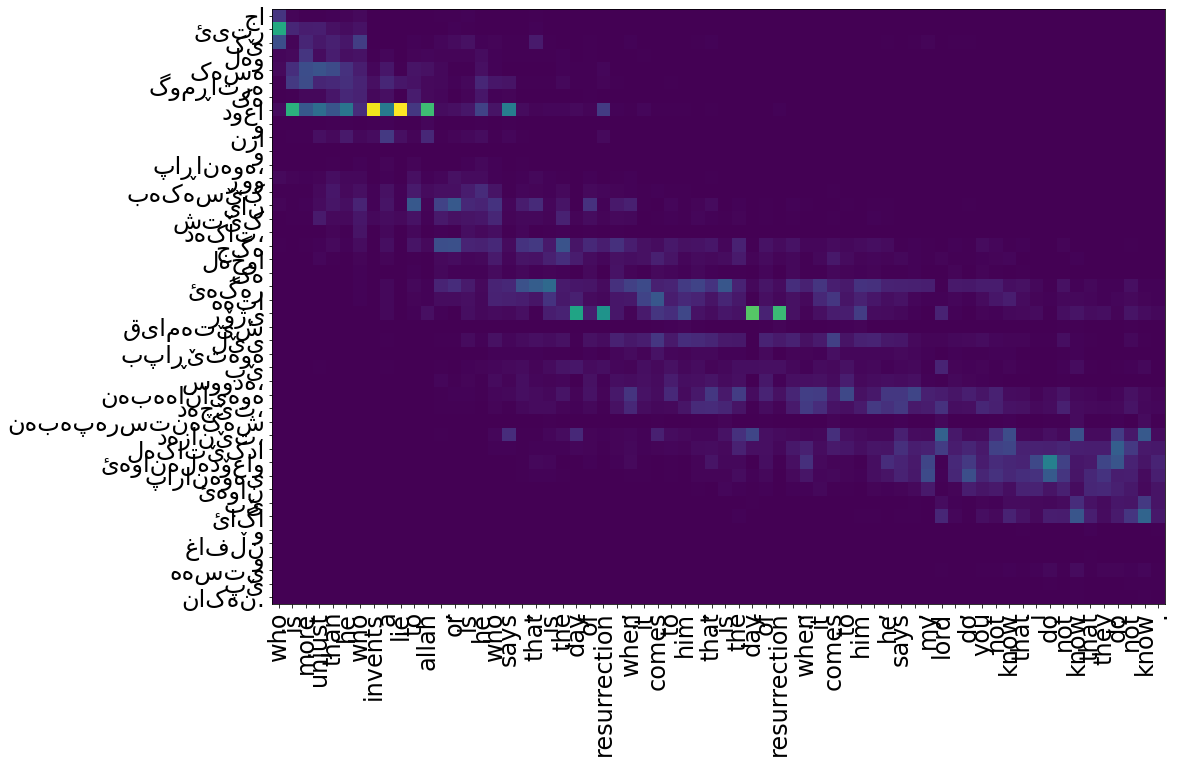

In [ ]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, \
                       base_dir=r"/content", \
                       filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Bleu Score on the test dataset

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = N_val_samples
scores = [0]*N_samples
print(N_samples)
for i in range(N_samples):
    print(i)
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

# Bleu Score for some samples of the corpus

In [ ]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = 1000
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")


Streaming output truncated to the last 5000 lines.
Bleu score: 0.7598356856515925
-------------------------------------------------------------------------------------------------------------------------
Sample: 286 in total number of 1000

Input Source sentence: کاتێکیش دوژمنان لەسەرو خوارتانەوە هاتنە سەرتان، کاتێکیش چاوەکان ئەبلەق بوون، دڵەکان گەشتبوونە گەروو، گومانی جۆراو جۆرتان دەبرد بەبەڵێنەکانی خوای گەورە .
Actual Target Translation: eyes became dull and hearts almost reached the throat when they attacked you from above and below and you started to think of god with suspicion .
Predicted Target Translation: and when they reached you from above you , and you turned forth from them , and you became the eyes of the throats .
Bleu score: 0.2370415522582106
-------------------------------------------------------------------------------------------------------------------------
Sample: 287 in total number of 1000

Input Source sentence: ئەوە بەهێزو دەسەڵاتی خۆمان دەمانگرت.
Actual Targe